In [41]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.coordinates as coord
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table

In [42]:
def make_df_field_centers(sc, nrows):
    # 'sc' is an Astropy SkyCoord object with the central RA, Dec coordinate                                                                   
    # 'nrows' is the number of rows of fields to be created in the Declination direction                                                       
    # 'nfields_width' is the number of fields in RA for the center row                                                                         

    # NOTE: 'nrows' must be an odd number                                                                                                      

# separation of field centers in degrees; DF FOV ~2.9x3.3; 10% field overlap                                                                   
    overlap_frac_ra = 0.165
    offset_ra_deg = (3.3*(1.0-overlap_frac_ra))*u.deg
    overlap_frac_dec = 0.145
    offset_dec_deg = (2.9*(1.0-overlap_frac_dec))*u.deg

    ra_offset = offset_ra_deg/np.cos(sc.dec.radian)
    dec_offset = offset_dec_deg

    rownums = np.arange(nrows)-int(nrows/2)

    fields_ra = []
    fields_dec = []

# Row "0" is the one centered on the target. No shift applied to each row.                                                                     
# The number of fields in each row is "nfields_width" for row 0, or generally: "nfields_width - N" for row N                                   

    for row in rownums:
        if np.abs(row) >= 0:
            nfields_row = 11 #np.abs(row+1)                                                                                                   
            rashifts = np.arange(nfields_row) - int(nfields_row/2)
            #if np.mod(row, 2) == 0:                                                                                                           
            #    rashifts = np.arange(nfields_row) - int(nfields_row/2)                                                                        
            #else:                                                                                                                             
            #    rashifts = np.arange(nfields_row) - int(nfields_row/2) + 0.5                                                                  

            racen = sc.ra + (rashifts*ra_offset)
            deccen = racen*0.0 + (sc.dec - (row*dec_offset))

            fields_ra = np.append(fields_ra, racen.value)
            fields_dec = np.append(fields_dec, deccen.value)

    fields_ra = np.array(fields_ra)
    fields_dec = np.array(fields_dec)

    return fields_ra, fields_dec


In [43]:
## M33:                                                                                                                                        
#sc0 = SkyCoord(ra='01h33m50.904s',dec='30d39m34.79s',distance=880.0*u.kpc,frame='icrs')
sc0 = SkyCoord(ra='01h40m0s',dec='30d39m34.79s',distance=880.0*u.kpc,frame='icrs')

targetname = 'M33'
sc=sc0


In [44]:
### Select the field centers:                                                                                                                  
#ra_fields, dec_fields = make_field_centers(sc, 22)                                                                                            
ra_fields, dec_fields = make_df_field_centers(sc, 7)

sc_fields_all = SkyCoord(ra = ra_fields*u.deg, dec = dec_fields*u.deg, frame='icrs')
sc_fields_sep = sc_fields_all.separation(sc0)

# Remove a few to fit within a 2-night observing request:                                                                                      
keep_fields = sc_fields_all.ra.value < 0 # create boolean array with all values True                                                           
#keep_fields[((sc_fields_sep.degree) < 3.5*170./50.)] = True                                                                                   
keep_fields[((sc_fields_sep.degree) < 3.5*170./50.) & ((sc_fields_sep.degree) > 2.0)] = True
#keep_fields[((sc_fields_sep.degree) < 3.5*100./50.) & ((sc_fields_sep.degree+0.75) > 3.5)] = True                                             
pd_fields = (sc_fields_all.ra.value < 22.7) & (sc_fields_all.dec.value > 30.75)
keep_fields[pd_fields]=False
sc_fields = sc_fields_all[keep_fields]

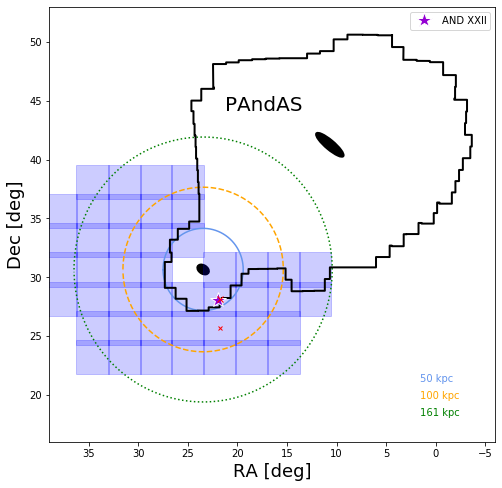

In [57]:
from astropy.coordinates import CartesianRepresentation, SphericalRepresentation, Angle, SkyCoord

n = 10000
rvir = 161.
d = 794.
m33 = sc0

fieldcen = m33

fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111)
plt.xlabel('RA [deg]', fontsize=18)
plt.ylabel('Dec [deg]', fontsize=18)
and22 = SkyCoord('01h27m40.0s','28d05m25s', unit='deg')
m33 = SkyCoord('01h33m50.0s','30d39m37s', unit='deg')
m31 = SkyCoord('0h42m44.3s', '41d16m9s', unit='deg')
plt.plot(and22.ra.deg, and22.dec.deg, '*', color='darkviolet' ,mec='white',ms=16, label='AND XXII', zorder=5)

# unit circle at Dec=30 deg.                                                                                                                   
cpts = np.arange(0,360.0,1)
xpts = 1.0*np.cos(np.deg2rad(cpts))/np.cos(30.0*u.deg)
ypts = 1.0*np.sin(np.deg2rad(cpts))

xcirc50 = (xpts*3.5)+m33.ra.value
ycirc50 = (ypts*3.5)+m33.dec.value

plt.plot(xcirc50,ycirc50,color='cornflowerblue')

xcirc100 = (xpts*3.5*100.0/50.0)+m33.ra.value
ycirc100 = (ypts*3.5*100.0/50.0)+m33.dec.value

plt.plot(xcirc100,ycirc100,color='orange',ls='--')

xcirc161 = (xpts*3.5*161.0/50.0)+m33.ra.value
ycirc161 = (ypts*3.5*161.0/50.0)+m33.dec.value

plt.plot(xcirc161,ycirc161,color='green',ls=':')

dp = np.loadtxt('corners_PAndAS11.txt')
ra = dp[:,0]
dec = dp[:,1]
plt.plot(ra, dec, lw=2, color='k')
plt.xlim(*plt.xlim()[::-1])
plt.figtext(0.43, 0.7, 'PAndAS', fontsize=20, color='k')
circle= plt.Circle((m33.ra.deg, m33.dec.deg), 3.5, fill=False, color='cornflowerblue', lw=2, label='50 kpc')
circle2 = plt.Circle((m33.ra.deg, m33.dec.deg), 3.5*rvir/50., fill=False, color='green', lw=2, ls=':')
circle3 = plt.Circle((m33.ra.deg, m33.dec.deg), 3.5*100./50., fill=False, color='orange', lw=2, ls='--')

plt.xlim(39,-6)
plt.ylim(16,53)

from matplotlib.patches import Circle, Wedge, Polygon, Ellipse, Rectangle
from matplotlib.collections import PatchCollection
ring = Wedge((m33.ra.deg, m33.dec.deg), 3.5*100./50., 0, 360, width=(3.5*100./50. - 3.5)),  # Full ring                                        
p = PatchCollection(ring, alpha=0.1)
p.set_color('orange')

m31ell = Ellipse((m31.ra.deg, m31.dec.deg), (200./60.0), (50.0/60.0), angle=35, fill=True, linewidth=2, color='k')
ax.add_patch(m31ell)

m33ell = Ellipse((m33.ra.deg, m33.dec.deg), (73./60.0), (45.0/60.0), angle=23, fill=True, linewidth=2, color='k')
ax.add_patch(m33ell)

rasize = 3.3
decsize = 2.9

plt.plot(21.796717940683287, 25.700663888888887,'rx', ms=4)
plt.plot(21.796717940683287, 28.180163888888885,'rx', zorder=1000)


for i in range(len(sc_fields)):
    field = Rectangle([sc_fields[i].ra.deg-rasize/2, sc_fields[i].dec.deg-decsize/2], 3.3, 2.9, color='b', fill=True, alpha=0.2)
    ax.add_patch(field)

plt.legend(numpoints=1)
plt.figtext(0.77, 0.23, r'50 kpc', color='cornflowerblue')
plt.figtext(0.77, 0.2, r'100 kpc', color='orange')
plt.figtext(0.77, 0.17, r'161 kpc', color='green')
plt.savefig('M33_Dragonfly_fields_test_shift.png')

In [50]:
for i in range(len(sc_fields)):
    if 20. < sc_fields[i].ra.deg < 25.:
        print(sc_fields[i].ra.deg, sc_fields[i].dec.deg)

24.999999999999996 38.098163888888884
24.999999999999996 35.61866388888889
24.999999999999996 33.13916388888889
21.796717940683287 30.659663888888886
21.796717940683287 28.180163888888885
24.999999999999996 28.180163888888885
21.796717940683287 25.700663888888887
24.999999999999996 25.700663888888887
21.796717940683287 23.22116388888889
24.999999999999996 23.22116388888889
